# Homework 4 (100 Points)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/CS506-Spring23-Homework4")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


## Exercise 1 (40pts)

In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data you will be working with comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

### Part 1 (20pts)

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [ ]:
from collections import defaultdict
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):
    df = load_tsv_dataset(path_to_dataset)
    dictonary = set(load_feature_dictionary("data/word2vec.txt").keys())

    trimmed_reviews = []
    for label, review in df:
      words = review.split()
      trimmed_words = [word for word in words if word in dictonary]
      trimmed_review = " ".join(trimmed_words)
      trimmed_reviews.append((label, trimmed_review))

    return np.array(trimmed_reviews, dtype=df.dtype)

trim_train = trim_reviews("data/train_small.tsv")
trim_test = trim_reviews("data/test_small.tsv")

b) Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function. (10pts)

In [ ]:
def embed_reviews(trimmed_dataset):
    word2vec_map = load_feature_dictionary("data/word2vec.txt")
    embedded_dataset = []
    for label, review in trimmed_dataset:
        words = review.split()
        embeddings = [word2vec_map[word] for word in words if word in word2vec_map]
        if len(embeddings) > 0:
            embedded_review = np.mean(embeddings, axis=0)
        else:
            embedded_review = np.zeros(VECTOR_LEN)
        row = np.concatenate([[label], embedded_review])
        embedded_dataset.append(row)
    return np.array(embedded_dataset)

def save_as_tsv(dataset, filename):
    with open(filename, 'w+') as f:
        lines = []
        for row in dataset:
            row_str = "\t".join([str(round(x, 6)) for x in row])
            lines.append(row_str + "\n")
        f.writelines(lines)
    return 

embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

save_as_tsv(embedded_train, "data/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "data/output/embedded_test_small.tsv")

In [ ]:
np.loadtxt("data/output/embedded_train_small.tsv", delimiter='\t')

array([[ 1.      , -0.166646,  0.641027, ..., -0.796929, -0.166708,
        -0.992398],
       [ 0.      , -0.224874,  0.461526, ..., -0.260568, -0.057   ,
        -1.058874],
       [ 0.      , -0.222178,  0.437475, ..., -0.148741, -0.023637,
        -0.963004],
       ...,
       [ 0.      , -0.21248 ,  0.643195, ..., -0.284662, -0.223277,
        -1.030322],
       [ 1.      , -0.221929,  0.800031, ..., -0.07151 , -0.491582,
        -1.138122],
       [ 1.      , -0.202339,  0.455211, ..., -0.325936, -0.206248,
        -1.101101]])

In [ ]:
np.loadtxt("data/output/embedded_test_small.tsv", delimiter='\t')

array([[ 0.      , -0.203273,  0.425525, ..., -0.398719, -0.542986,
        -1.175144],
       [ 0.      , -0.231991,  0.304819, ..., -0.697397, -0.196655,
        -1.161086],
       [ 1.      , -0.211579,  0.677157, ..., -0.43044 , -0.666509,
        -0.993239],
       ...,
       [ 1.      , -0.220395,  0.926426, ..., -0.41029 , -0.476321,
        -0.928512],
       [ 1.      , -0.226557,  0.697262, ..., -0.779591, -0.499161,
        -0.838087],
       [ 0.      , -0.223464,  0.208776, ..., -0.537888, -0.303256,
        -1.197632]])

### Part 2 (20pts)

In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.

Some rules:

1. Include an intercept term in your model. You must consider the bias term as part of the weight vector and not a separate term to keep track of.
2. Initialize all model parameters to 0
3. Use vector and matrix multiplication

The expected `metrics.txt` from the dataset with `500` epochs and `0.01` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

We will be testing your code on other, larger datasets.

In [ ]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gd(theta, X, y, learning_rate):
    # TODO: implement in vector form
    theta = theta - learning_rate * ((np.dot((sigmoid(np.dot(X, theta)) - y), X))/len(y))
    return theta


def train(theta, X, y, num_epoch, learning_rate):
    for _ in range(num_epoch):
        theta = gd(theta, X, y, learning_rate)
    return theta


def predict(theta, X):
    # TODO: implement in vector form
    return (sigmoid(np.dot(X, theta)) >= 0.5)


def compute_error(y_pred, y):
    # TODO: implement in vector form
    return np.sum(np.abs(y_pred - y)) / len(y)


def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return


def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate): 
    y = load_tsv_dataset(formatted_train)[:, 0]
    X = load_tsv_dataset(formatted_train)[:, 1:]
    theta = np.zeros(X.shape[1])

    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)

    X_test = load_tsv_dataset(formatted_test)[:, 1:]
    y_test = load_tsv_dataset(formatted_test)[:, 0]
    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    return


logistic_reg("data/output/embedded_train_small.tsv", "data/output/embedded_test_small.tsv", "data/output/metrics.txt", 500, 0.01)

In [ ]:
print(open("data/output/metrics.txt").read())

error(train): 0.000000
error(test): 0.625000



## Exercise 2 (60 Points)

For this exercise, recall the lab's kaggle competition where you predicted if a cookie was defective or not (assuming you attend labs). For more information on the data and details, [click here to view the competition and data details](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/data)

However, what we will do differently here is check if two of the features were correlated. This is important because if two features are correlated, then we can remove one of the features and still get the same information. This is part of the feature selection process.

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from scipy import stats

**a)** (1 Point) Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

In [3]:
#Code in this cell
cookie_train_df = pd.read_csv('data/cookie_train.csv')
cookie_test_df = pd.read_csv('data/cookie_test.csv')

### Combining Training and Testing Data

The lab did not have a lot of cookies for the training set, so what we will do is combine the training and testing data together without any loss of generality.

**b)** (3 Point) Combine the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable). Make sure to label your axes and give your plot a title.

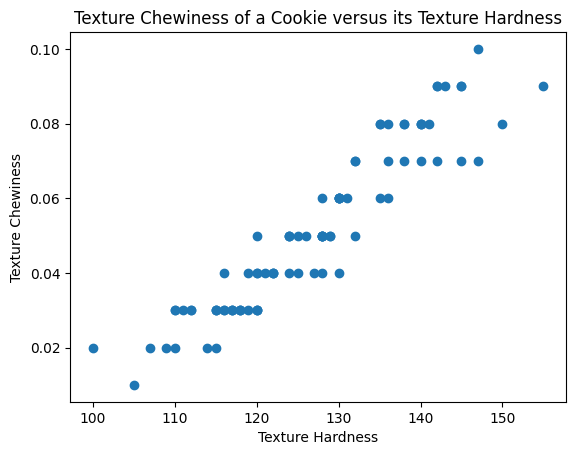

In [4]:
#Code in this cell
combined_df = pd.concat([cookie_train_df, cookie_test_df])
plt.scatter(combined_df["Texture Hardness"], combined_df["Texture Chewiness"])
plt.xlabel("Texture Hardness")
plt.ylabel("Texture Chewiness")
plt.title("Texture Chewiness of a Cookie versus its Texture Hardness")
plt.show()

### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


**c) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

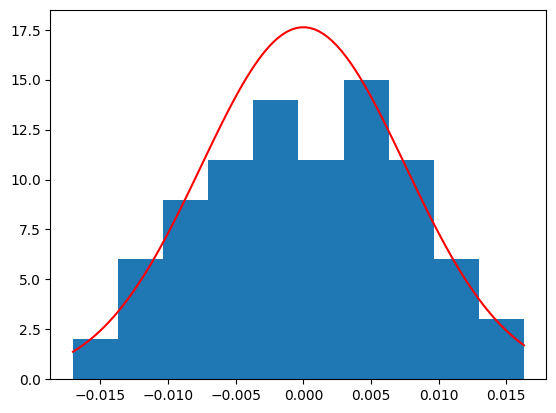

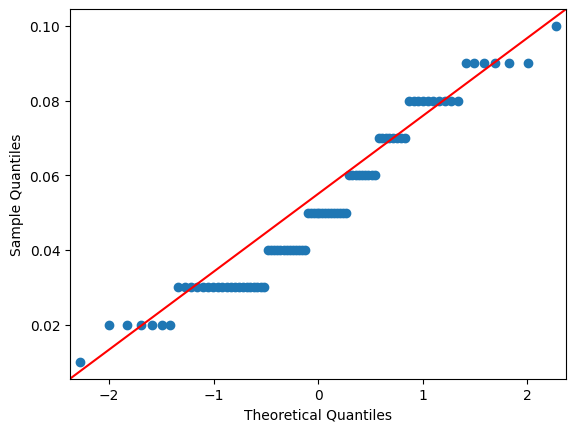

In [7]:
#Plot in this cell
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_df["Texture Hardness"], combined_df["Texture Chewiness"])
#plotting histogram of residuals
residuals = combined_df["Texture Chewiness"] - (slope * combined_df["Texture Hardness"] + intercept)
plt.hist(residuals)
#plotting normal distribution centered at mean 0, as epsilon ~ N(0, sigma^2)
min_residual = min(residuals)
max_residual = max(residuals)
std_residual = np.std(residuals)
x = np.linspace(min_residual, max_residual, 100)
plt.plot(x, stats.norm.pdf(x, 0, std_residual)/3, color='red', linestyle='-')
plt.show()

sm.qqplot(combined_df["Texture Chewiness"]) # alternatively make a QQ plot
# drawing a line
plt.plot([0, 1], [0, 1], color='red', transform=plt.gca().transAxes)
plt.show()



> If we plot the residuals' histogram, we can see it mimic a normal distribution. Now this interpretation can go two ways: 1) the data is approximately normal, but is slightly skewed to the right. If necessary, we can fix this by transforming the data. 2) The data is arguably close enough to be normal, keeping in mind statistical ideas such as the Central Limit Theorem (student does not need to mention CLT since it wasn't taught but if they included it then it would be nice).

> If they used QQ plot, if they said it was slightly skewed to the right, they should mention the points are below the line or seem to be more concented to be below the line. If they said it was approximately normal, they should at least mention that the points are close to the line or they are proceeding with caution to receive credit.



#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

**d) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

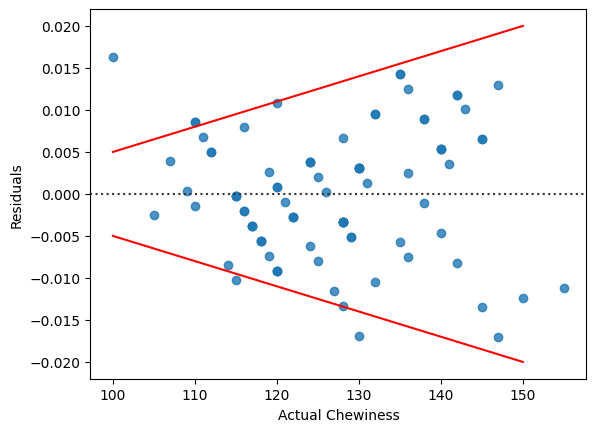

In [ ]:
#Plot in this cell
sns.residplot(x=combined_df["Texture Hardness"], y=combined_df["Texture Chewiness"])
plt.ylabel("Residuals")
plt.xlabel("Actual Chewiness")

var_line_y_int_upper_bound = 0.005
var_line_y_int_lower_bound = -0.005

var_line_slope_upper_bound = 3
var_line_slope_lower_bound = 4

#lines to see how the variance is not constant
plt.plot([100, 150], [var_line_y_int_upper_bound, var_line_y_int_upper_bound+var_line_slope_upper_bound*var_line_y_int_upper_bound], color='red')
plt.plot([100, 150], [var_line_y_int_lower_bound, var_line_slope_lower_bound*var_line_y_int_lower_bound], color='red')
plt.show()



> The data is not homoscedastic, as we see in above the variance among the residuals is not constant. We can fix this data specifically by transforming the data.

> Do not give credit for students who argue this is homoscedastic, as a clear conical shape is visible.


#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

**e) (5 Points)** Use the Durbin-Watson test to determine if the explanatory variable and response variable are independent. State whether if the independence assumption is met or not. If it is not met, state what can we do to fix this. You may use any library to do this, and for more information, check out [this link](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).

In [ ]:
#Code in this cell

model = LinearRegression().fit(combined_df["Texture Hardness"].to_numpy().reshape(-1, 1), combined_df["Texture Chewiness"]) 
residuals = combined_df["Texture Chewiness"] - model.predict(combined_df["Texture Hardness"].to_numpy().reshape(-1, 1))
durbin_watson(residuals)

2.2797136857816565

> The Durbin-Watson test gives us a value of approximately `2.279`, yielding a result that the explanatory and response variables are independent. 
> 
> If the value was significantly less than 2, we would say that there is positive autocorrelation. If the value was significantly greater than 2, we would say that there is negative autocorrelation. If the value was around 2, we would say that there is no autocorrelation. No other answer is acceptable.



#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

**f) (6 Points)** If you think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

And the DW test yields: 2.2890518075403037


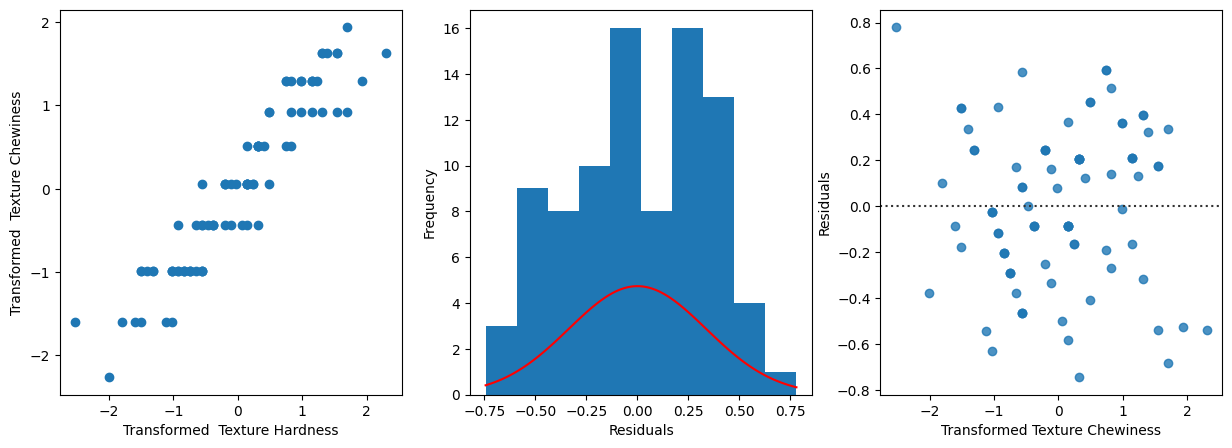

In [9]:
#Code in this cell

#NOTE: for some reason np.log doesn't work well so we have used PowerTransformer
transformed_df = combined_df.copy()
transformed_df["Texture Hardness"] = PowerTransformer().fit_transform(transformed_df["Texture Hardness"].values.reshape(-1, 1))
transformed_df["Texture Chewiness"] = PowerTransformer().fit_transform(transformed_df["Texture Chewiness"].values.reshape(-1, 1))

#renaming columns to accurately display the transformation
transformed_df.rename(columns={"Texture Hardness": "log Texture Hardness", "Texture Chewiness": "log Texture Chewiness"}, inplace=True)

#fitting it with linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(transformed_df["log Texture Hardness"], transformed_df["log Texture Chewiness"])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#scatter plot
axs[0].scatter(transformed_df["log Texture Hardness"], transformed_df["log Texture Chewiness"])
axs[0].set_xlabel("Transformed  Texture Hardness")
axs[0].set_ylabel("Transformed  Texture Chewiness")

#residual plot
sns.residplot(x=transformed_df["log Texture Hardness"], y=transformed_df["log Texture Chewiness"])
axs[2].set_ylabel("Residuals")
axs[2].set_xlabel("Transformed Texture Chewiness")

#qq plot
residuals = transformed_df["log Texture Chewiness"] - (slope * transformed_df["log Texture Hardness"] + intercept)
axs[1].hist(residuals)
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Frequency")
#adding a normal distribution
min_residual = min(residuals)
max_residual = max(residuals)
std = np.std(residuals)
x = np.linspace(min_residual, max_residual, 100)
axs[1].plot(x, 4*stats.norm.pdf(x, 0, std), color='red', linestyle='-')

print("And the DW test yields:",durbin_watson(residuals))

> Applying a Power Transformer to x and y, we now have a model that is approximately linea and has homoscedastic behavior among the residuals --- we can easily ignore the single outlier point around `Actual log Chewiness ~ -2.5` . The Durbin-Watson test gives us a value of `2.2891`, which is very close to 2. This means that there is no autocorrelation between the residuals, implying independence. 
>
> Note that the histogram of the residuals is not perfectly normal, but it is close enough to be considered normal by its symmetric-like behavior (can also say this is very slightly skewed to the right). The student should acknowledge that if they have something like this, that the shape is still approximately symmetric. The QQ plot is also close enough to be considered normal.
> 
> Any transformation that yields similar results is acceptable too. However, do not give credit for students who argue that the model is already good enough and for students who do not acknowledge the flaws in their model, including hetereoscedasticity, non-normality, and/or autocorrelation values yielded by the Durbin-Watson test.

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

**g) (5 Points)** Use the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

In [ ]:
#Your code in this cell
slope, intercept, r_value, p_value, std_err = stats.linregress(transformed_df["log Texture Hardness"], transformed_df["log Texture Chewiness"])
print("The p-value is:", p_value)

The p-value is: 2.0463850373363904e-42


> With the p-value being exceedingly small and no where near the proposed alpha value of 0.05, we can reject the null hypothesis and conclude that the log Texture Hardness is a significant predictor of the log Texture Chewiness.

### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

**h) (10 Points)** Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

_You may use the transformed model made (if one was made) from the previous parts and add this new feature to it._

In [ ]:
#Your code in this cell
transformed_df["Taste Sweetness"] = combined_df["Taste Sweetness"]

sm.OLS(transformed_df["log Texture Chewiness"], transformed_df[["log Texture Hardness", "Taste Sweetness"]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     log Texture Chewiness   R-squared (uncentered):                   0.888
Model:                               OLS   Adj. R-squared (uncentered):              0.885
Method:                    Least Squares   F-statistic:                              340.4
Date:                   Tue, 11 Apr 2023   Prob (F-statistic):                    1.38e-41
Time:                           20:19:07   Log-Likelihood:                         -28.597
No. Observations:                     88   AIC:                                      61.19
Df Residuals:                         86   BIC:                                      66.15
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
log Texture Hardness     0.9310      0.038     24.722      0.000       0.856       1.006
Taste Sweetness          0.0137      0.014      0.989      0.325      -0.014       0.041
==============================================================================
Omnibus:                        3.047   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                1.935
Skew:                          -0.127   Prob(JB):                        0.380
Kurtosis:                       2.319   Cond. No.                         2.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The log Texture Hardness, having a P-value of 0.000 is a significant predictor, but the Taste Sweetness with a p-value of 0.325 is not a significant predictor using the $\alpha = 0.001$ significance level. We can also see the overall model is a good fit, as the F-statistic p-value is very close to 0. 
> 
> Note these results may vary based off what transformation students made, but similar reasoning is required. Students were not taught to analyze the F-test statistic, so they should just analyze the t-test statistic, R squared, and/or the Durbin-Watson test statistic.

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

**i) (10 Points)** Interpret the coefficients of the model made in part **h**. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.



> For every unit increase in the `Transformed Texture Hardness`, the `Transformed Texture Chewiness` increases by 0.931. For every unit increase in the `Transformed Taste Sweetness`, the `Transformed Texture Chewiness` increases by 0.0137. This means that the `Transformed Texture Hardness` is a better predictor of the `Transformed Texture Chewiness` than the `Transformed Taste Sweetness`. This makes sense as the `Transformed Texture Hardness` has a higher t-statistic value than the `Transformed Taste Sweetness`. This makes sense as the `Transformed Texture Hardness` yields a higher t-statistic value than the `Transformed Taste Sweetness` and additionally rejects the null hypothesis whereas `Taste Sweetness` does not.
>
> Looking at the Durbin-Watson test statistic, we can see that there is no autocorrelation between the residuals, implying independence. 
>
> We can also see a large R squared value of 0.888, which means that the model explains 88.8% of the variation in the data. This is a very good fit.
>
> Give partial credit for solutions that only cover some of the detail mentioned above. As students did not learn the other statistics, they should not be expected to know them or use them.



### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

**j) (10 Points)** Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any). You may use any library to do this.

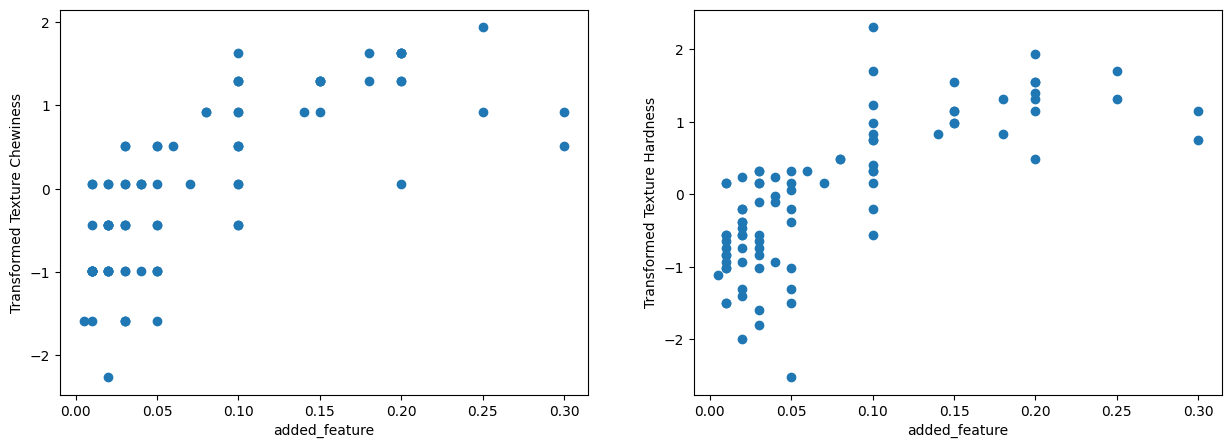

In [ ]:
transformed_df["added_feature"] = combined_df["Taste Bitterness"]
#plotting 2 scatter plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(transformed_df["added_feature"], transformed_df["log Texture Chewiness"])
axs[0].set_xlabel("added_feature")
axs[0].set_ylabel("Transformed Texture Chewiness")

axs[1].scatter(transformed_df["added_feature"], transformed_df["log Texture Hardness"])
axs[1].set_xlabel("added_feature")
axs[1].set_ylabel("Transformed Texture Hardness")
plt.show()

> The data clearly looks similar to $\hat{y} = \sqrt{x}+\epsilon$ where $\epsilon \approx N(0, \sigma^2)$, so we will try a similar transformation:

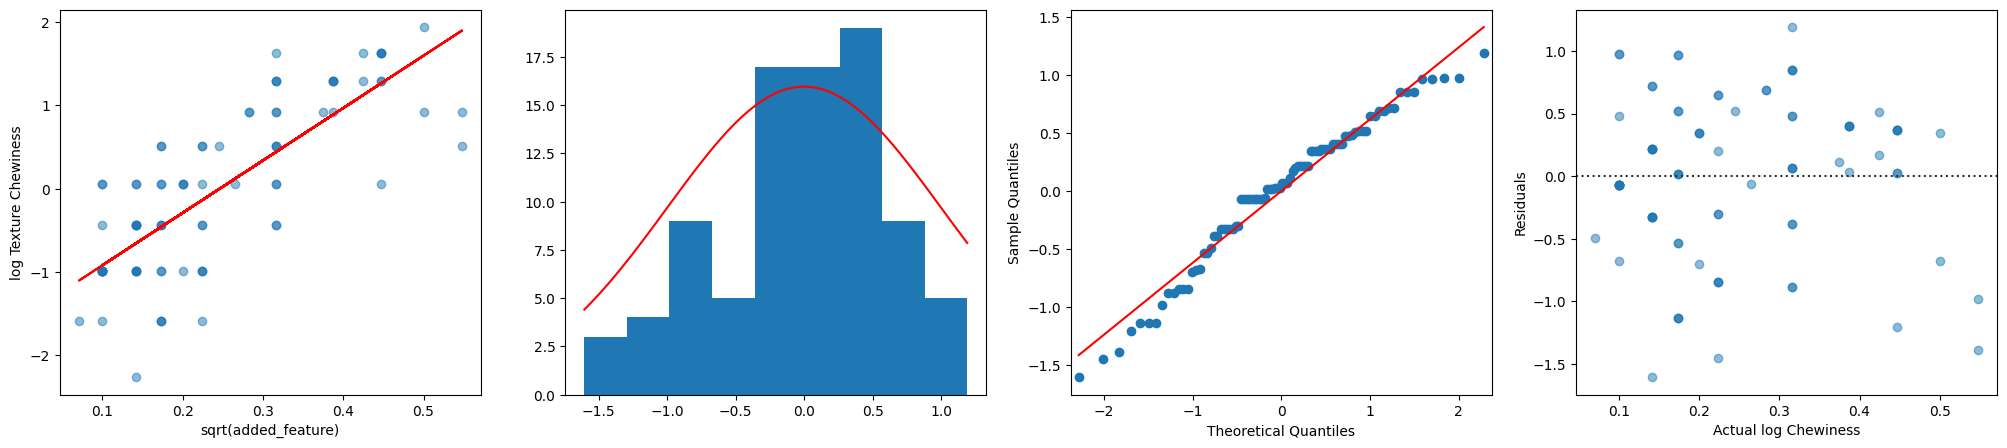

In [10]:
transformed_df["added_feature"] = combined_df["Taste Bitterness"]

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

#transformation to make it linear with this setup: added_feature |-> np.sqrt(added_feature)
transformed_df["sqrt(added_feature)"] = np.sqrt(transformed_df["added_feature"])

#conducting linear regression fit
slope, intercept, r_value, p_value, std_err = stats.linregress(transformed_df["sqrt(added_feature)"], transformed_df["log Texture Chewiness"])

#scatter plot
axs[0].scatter(transformed_df["sqrt(added_feature)"], transformed_df["log Texture Chewiness"], alpha=0.5)
axs[0].set_xlabel("sqrt(added_feature)")
axs[0].set_ylabel("log Texture Chewiness")
#drawing line
axs[0].plot(transformed_df["sqrt(added_feature)"], slope*transformed_df["sqrt(added_feature)"] + intercept, color='red', linestyle='-')

#computing residuals
transformed_df["residuals"] = transformed_df["log Texture Chewiness"] - (slope*transformed_df["sqrt(added_feature)"] + intercept)
#plotting a normal distribution
min_residual = min(transformed_df["residuals"])
max_residual = max(transformed_df["residuals"])
axs[1].plot(np.linspace(min_residual, max_residual, 100), 40*stats.norm.pdf(np.linspace(min_residual, max_residual, 100), 0, 1), color='red', linestyle='-')

#plotting residuals histogram
axs[1].hist(transformed_df["residuals"], bins=int(np.sqrt(len(transformed_df["residuals"])))) #sqrt rule

#plotting qq
sm.qqplot(transformed_df["residuals"], line='s', ax=axs[2])

#plotting residual plot
sns.residplot(x=transformed_df["sqrt(added_feature)"], y=transformed_df["log Texture Chewiness"], scatter_kws={"alpha": 0.5}, ax=axs[3])
axs[3].set_ylabel("Residuals")
axs[3].set_xlabel("Actual log Chewiness")


plt.show()

> Everything here looks good except for the normality assumption: the histogram of the residuals is not perfectly normal, but it is close enough to be considered normal by its symmetric-like behavior (can also say this is very slightly skewed to the right). The student should acknowledge that if they have something like this, that the shape is still approximately symmetric. The QQ plot is also close enough to be considered normal and respectivrly can be argued to be slightly skewed to the right with the a decent number of points being below the line.

In [11]:
#doing hypothesis testing
transformed_df.rename(columns={"sqrt(added_feature)": "sqrt(Taste Bitterness)"}, inplace=True)
sm.OLS(transformed_df["log Texture Chewiness"], transformed_df[["log Texture Hardness", "sqrt(Taste Bitterness)"]]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     log Texture Chewiness   R-squared (uncentered):                   0.887
Model:                               OLS   Adj. R-squared (uncentered):              0.885
Method:                    Least Squares   F-statistic:                              339.2
Date:                   Sat, 22 Apr 2023   Prob (F-statistic):                    1.59e-41
Time:                           02:41:17   Log-Likelihood:                         -28.737
No. Observations:                     88   AIC:                                      61.47
Df Residuals:                         86   BIC:                                      66.43
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
log Texture Hardness       0.9304      0.039     24.133      0.000       0.854       1.007
sqrt(Taste Bitterness)     0.1171      0.140      0.838      0.404      -0.161       0.395
==============================================================================
Omnibus:                        3.314   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.088
Skew:                          -0.151   Prob(JB):                        0.352
Kurtosis:                       2.309   Cond. No.                         3.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Similar stuff said when interpreting variable in previous part is acceptable here
>
> Give partial credit based off how much they show in their solution and their explanations, similar to here.

## Bonus (20pts)

Lasso Regression is a modification of Regression that adds a regularization penalty to the the parameter $\mathbf{\beta}$ learned by the model. The loss function for Lasso is the following:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 + \lambda \Vert \mathbf{\beta} \Vert = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y} + \lambda \Vert \mathbf{\beta} \Vert$$

Where $\lambda$ is a tuning parameter specified by the user.

Using worksheet 17 as a guide:

1. create an animation like in part c) for Lasso Regression. [15pts]

In [14]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from IPython.display import Image

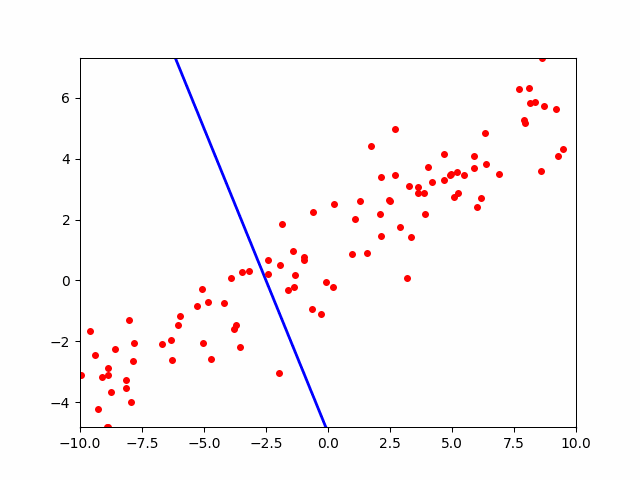

In [18]:
b0 = np.arange(-5, 4, 0.1)
b1 = np.arange(-5, 4, 0.1)
b0, b1 = np.meshgrid(b0, b1)

beta = np.array([ 1 , .5 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

def loss(X, y, beta, lmbda):
    return beta.T @ X.T @ X @ beta - 2 * beta.T @ X.T @ y + y.T @ y + lmbda * np.sum(np.abs(beta))

def gradient(X, y, beta, lmbda):
    y_pred = X @ beta
    l2_grad = 2 * X.T @ (y_pred - y)
    l1_grad = lmbda * np.sign(beta)
    return l2_grad + l1_grad

TEMPFILE = "temp.png"

def snap_model(beta):
    xplot = np.linspace(-10,10,50)
    yestplot = beta[0] + beta[1] * xplot
    fig, ax = plt.subplots()
    ax.plot(xplot, yestplot,'b-',lw=2)
    ax.plot(xlin, y,'ro',markersize=4)
    ax.set_xlim(-10, 10)
    ax.set_ylim(min(y), max(y))
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))


def gradient_descent(X, y, beta_hat, learning_rate, epochs, images, lmbda):
    losses = [loss(X, y, beta_hat, lmbda)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(snap_model(beta_hat))
        beta_hat = beta_hat - learning_rate * gradient(X, y, beta_hat, lmbda)

        losses.append(loss(X, y, beta_hat, lmbda))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)

beta_start = np.array([-5, -2])
learning_rate = 0.0002 # try .0005
images = []
lmbda = 0.1
betas, losses = gradient_descent(X, y, beta_start, learning_rate, 100, images, lmbda)

images[0].save(
    'lr.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

Image(open('lr.gif', 'rb').read())

2. create at least two more animations using different values for $\lambda$ and the true $\mathbf{\beta}$ you used to generate the dataset (try steeper / less steep curves, and higher or close to zero intercepts). Briefly explain some key takeaways on how to tune $\lambda$. [5pts]

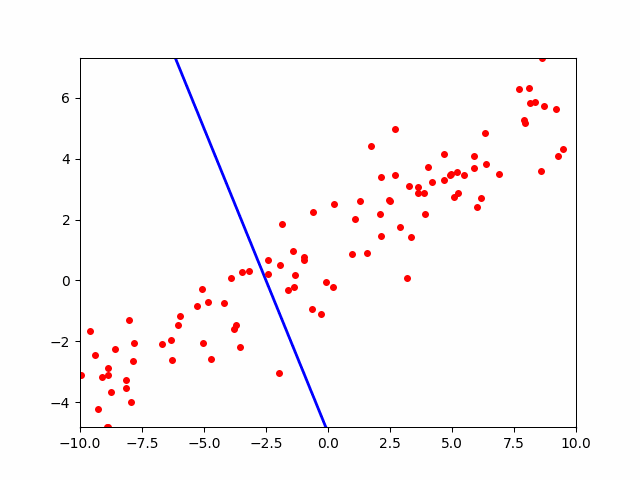

In [19]:
# Animation 1
beta1 = np.array([1, 1])
y1 = beta1[0]+(beta1[1]*xlin)+np.random.randn(100)

images = []
lmbda1 = 1
betas1, losses1 = gradient_descent(X, y1, beta_start, learning_rate, 100, images, lmbda1)
images[0].save(
    'lr_1.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

Image(open('lr_1.gif', 'rb').read())

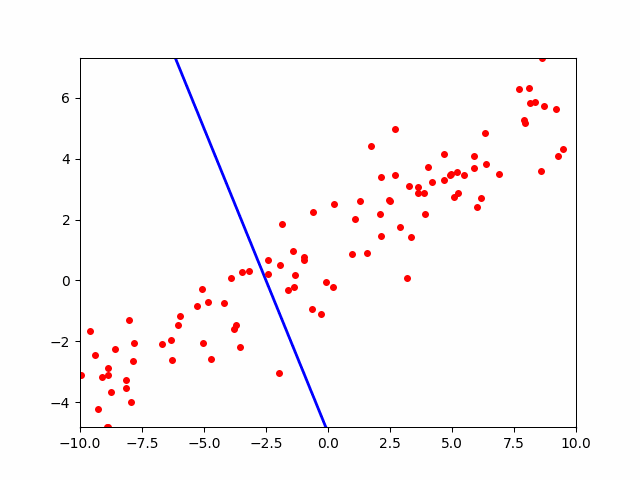

In [20]:
# Animation 2
beta2 = np.array([2, -1])
y2 = beta2[0]+(beta2[1]*xlin)+np.random.randn(100)

images = []
lmbda2 = 5
betas2, losses2 = gradient_descent(X, y2, beta_start, learning_rate, 100, images, lmbda2)
images[0].save(
    'lr_2.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

Image(open('lr_2.gif', 'rb').read())

* A larger value of λ results in more sparsity (fewer coefficients different from zero) in the learned model.
* A smaller value of λ results in a less sparse model (more coefficients different from zero), but potentially better fit to the training data.